In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-7trszyly
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-7trszyly
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit ab8cb070fc2e96bf499387076c3549e5785fde3e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-1.0.8.dev0-py3-none-any.whl size=2309939 sha256=6d029ecebfa656d8a92e53a96d596f2d6c4a2a4a0d481cf1b9518f9e4a28b9b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-woh_kos3/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm
  Attempting uninstall: timm
    Found existing installation: timm 1.0.7
    Uninstalling timm-1.0.7:
      Successfully uninstalled timm-1.0.7


In [2]:
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
!pip install torchinfo
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [3]:
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms.v2 as v2


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
dir_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
test_ds = os.path.join(dir_path, 'test')
train_ds = os.path.join(dir_path, 'train')

In [7]:
train = ImageFolder(train_ds)
test = ImageFolder(test_ds)

class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}
class_dict = dict(Counter(train.targets))
class_dict

{0: 717, 1: 52, 2: 2560, 3: 1792}

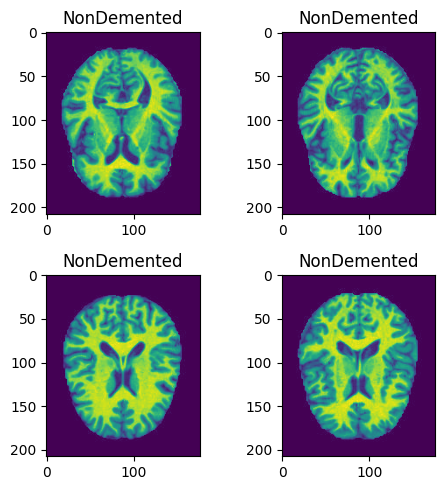

In [8]:
image_paths = []
for path in train.imgs:
    image_paths.append(path[0])
shuffled = image_paths.copy()
random.shuffle(shuffled)
plt.figure(figsize=(5,5))
for i, path in enumerate(shuffled):
    if i>3: break
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    image_class = Path(path).parent.stem
    plt.title(image_class)
    plt.imshow(img)
plt.tight_layout()

In [9]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx][0])
        class_category = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, class_category

In [10]:
transforms.functional.get_image_size(Image.open(train.imgs[1][0]))

[176, 208]

In [11]:
torchvision.transforms.functional.get_image_num_channels(Image.open(train.imgs[1][0]))

1

In [12]:
train_transform = v2.Compose([
                v2.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                v2.ToTensor()
])

test_transform = v2.Compose([
                v2.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                v2.ToTensor()
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [13]:
train_data, train_label = train.imgs, train.targets
test_data, test_label = test.imgs, test.targets

#os.path.join(dir_path,train_data)
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [14]:
train_dataset

In [15]:
import torch
from torch.utils.data import Subset, ConcatDataset
from sklearn.model_selection import StratifiedShuffleSplit

# Merge train and test data and labels
all_data = ConcatDataset([train_dataset, test_dataset])

# Extract labels from the combined dataset
labels = [label for _, label in all_data]

# Perform stratified shuffle split for train and test
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(all_data, train_indices_1)
test_data = Subset(all_data, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)


In [16]:
from collections import defaultdict

# Define a dictionary to store the counts of images in each class
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Iterate over train_data and count the occurrences of each class label
for _, label in train_data:
    train_class_counts[label] += 1

# Iterate over val_data and count the occurrences of each class label
for _, label in val_data:
    val_class_counts[label] += 1

# Iterate over test_data and count the occurrences of each class label
for _, label in test_data:
    test_class_counts[label] += 1

# Print the counts for train, val, and test datasets
print("Train Dataset Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation Dataset Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest Dataset Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train Dataset Class Counts:
Class 2: 2048 images
Class 3: 1433 images
Class 0: 574 images
Class 1: 41 images

Validation Dataset Class Counts:
Class 2: 512 images
Class 3: 359 images
Class 0: 143 images
Class 1: 10 images

Test Dataset Class Counts:
Class 3: 448 images
Class 0: 179 images
Class 2: 640 images
Class 1: 13 images


**Data loaded after stratified shuffle split**

In [17]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [18]:
num_classes = 4
model = timm.create_model('pit_ti_224', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, num_classes)
model.to(device)
summary(model, (3, 224, 224))  # Assumes input images of size (3, 224, 224)

model.safetensors:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 4]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [19]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [20]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr=0.0009)
scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

criterion = nn.CrossEntropyLoss()


In [21]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=10, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_weights = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
        else:
            self.best_score = score
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()

In [22]:
# Initialize early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

total_epochs = 50

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()

    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")

    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])

    scheduler.step()

    # Check early stopping
    early_stopping_callback(val_metrics['loss'], model)
    if early_stopping_callback.early_stop:
        print("Early stopping triggered")
        break

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Metrics - loss: 1.1064, accuracy: 0.4573, precision: 0.3675, recall: 0.4573, f1_score: 0.3942, specificity: 0.0000, sensitivity: 0.9974, mcc: -0.0113, auc: 0.5197


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.1038, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.4727


Training Model - Epoch [2/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0501, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.4948


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0373, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6331


Training Model - Epoch [3/50]: 100%|██████████| 64/64 [00:18<00:00,  3.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0460, accuracy: 0.4868, precision: 0.3623, recall: 0.4868, f1_score: 0.3589, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0142, auc: 0.4947


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0360, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6520


Training Model - Epoch [4/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0404, accuracy: 0.4998, precision: 0.3822, recall: 0.4998, f1_score: 0.3452, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0165, auc: 0.5086


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0512, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6327


Training Model - Epoch [5/50]: 100%|██████████| 64/64 [00:18<00:00,  3.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0450, accuracy: 0.4976, precision: 0.3703, recall: 0.4976, f1_score: 0.3419, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0007, auc: 0.4959


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0354, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6452


Training Model - Epoch [6/50]: 100%|██████████| 64/64 [00:18<00:00,  3.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0413, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.5034


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0366, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6753


Training Model - Epoch [7/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0384, accuracy: 0.5002, precision: 0.3864, recall: 0.5002, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0124, auc: 0.5153


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0420, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6574


Training Model - Epoch [8/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0061, accuracy: 0.4990, precision: 0.4414, recall: 0.4990, f1_score: 0.4371, specificity: 0.0226, sensitivity: 0.9901, mcc: 0.0801, auc: 0.5906


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0104, accuracy: 0.5000, precision: 0.2500, recall: 0.5000, f1_score: 0.3333, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6912


Training Model - Epoch [9/50]: 100%|██████████| 64/64 [00:18<00:00,  3.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9850, accuracy: 0.5210, precision: 0.4837, recall: 0.5210, f1_score: 0.4785, specificity: 0.0331, sensitivity: 0.9898, mcc: 0.1436, auc: 0.6352


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9592, accuracy: 0.5146, precision: 0.4045, recall: 0.5146, f1_score: 0.4045, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0899, auc: 0.7054


Training Model - Epoch [10/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9552, accuracy: 0.5303, precision: 0.5048, recall: 0.5303, f1_score: 0.4946, specificity: 0.0488, sensitivity: 0.9884, mcc: 0.1701, auc: 0.6582


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9509, accuracy: 0.5039, precision: 0.6016, recall: 0.5039, f1_score: 0.3419, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0653, auc: 0.7012


Training Model - Epoch [11/50]: 100%|██████████| 64/64 [00:18<00:00,  3.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9696, accuracy: 0.5166, precision: 0.4794, recall: 0.5166, f1_score: 0.4792, specificity: 0.0575, sensitivity: 0.9813, mcc: 0.1403, auc: 0.6523


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9566, accuracy: 0.5176, precision: 0.4120, recall: 0.5176, f1_score: 0.4112, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0988, auc: 0.7025


Training Model - Epoch [12/50]: 100%|██████████| 64/64 [00:18<00:00,  3.49it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9317, accuracy: 0.5498, precision: 0.5259, recall: 0.5498, f1_score: 0.5203, specificity: 0.0610, sensitivity: 0.9827, mcc: 0.2176, auc: 0.6868


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9164, accuracy: 0.5430, precision: 0.4475, recall: 0.5430, f1_score: 0.4855, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1750, auc: 0.7300


Training Model - Epoch [13/50]: 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9013, accuracy: 0.5620, precision: 0.5430, recall: 0.5620, f1_score: 0.5352, specificity: 0.0662, sensitivity: 0.9810, mcc: 0.2467, auc: 0.7123


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9230, accuracy: 0.5596, precision: 0.4850, recall: 0.5596, f1_score: 0.5186, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2333, auc: 0.7411


Training Model - Epoch [14/50]: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9211, accuracy: 0.5527, precision: 0.5383, recall: 0.5527, f1_score: 0.5200, specificity: 0.0523, sensitivity: 0.9901, mcc: 0.2191, auc: 0.7047


Validating Model: 100%|██████████| 16/16 [00:03<00:00,  4.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8988, accuracy: 0.5479, precision: 0.4719, recall: 0.5479, f1_score: 0.5066, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2084, auc: 0.7290


Training Model - Epoch [15/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8863, accuracy: 0.5676, precision: 0.5673, recall: 0.5676, f1_score: 0.5421, specificity: 0.0662, sensitivity: 0.9869, mcc: 0.2642, auc: 0.7377


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8721, accuracy: 0.5684, precision: 0.5637, recall: 0.5684, f1_score: 0.5633, specificity: 0.2657, sensitivity: 0.9319, mcc: 0.2775, auc: 0.7565


Training Model - Epoch [16/50]: 100%|██████████| 64/64 [00:18<00:00,  3.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8855, accuracy: 0.5593, precision: 0.5496, recall: 0.5593, f1_score: 0.5393, specificity: 0.1237, sensitivity: 0.9756, mcc: 0.2422, auc: 0.7483


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8715, accuracy: 0.5693, precision: 0.5656, recall: 0.5693, f1_score: 0.5424, specificity: 0.0350, sensitivity: 0.9875, mcc: 0.2785, auc: 0.7710


Training Model - Epoch [17/50]: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8405, accuracy: 0.5959, precision: 0.5913, recall: 0.5959, f1_score: 0.5822, specificity: 0.1847, sensitivity: 0.9665, mcc: 0.3155, auc: 0.7872


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8680, accuracy: 0.5908, precision: 0.5858, recall: 0.5908, f1_score: 0.5834, specificity: 0.2727, sensitivity: 0.9501, mcc: 0.3103, auc: 0.7848


Training Model - Epoch [18/50]: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8345, accuracy: 0.6003, precision: 0.5928, recall: 0.6003, f1_score: 0.5882, specificity: 0.2474, sensitivity: 0.9639, mcc: 0.3191, auc: 0.7930


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8492, accuracy: 0.6025, precision: 0.6293, recall: 0.6025, f1_score: 0.6050, specificity: 0.4056, sensitivity: 0.9444, mcc: 0.3585, auc: 0.8072


Training Model - Epoch [19/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8095, accuracy: 0.6172, precision: 0.6045, recall: 0.6172, f1_score: 0.6058, specificity: 0.2683, sensitivity: 0.9523, mcc: 0.3504, auc: 0.8105


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8613, accuracy: 0.5576, precision: 0.5690, recall: 0.5576, f1_score: 0.5449, specificity: 0.1329, sensitivity: 0.9705, mcc: 0.2626, auc: 0.7973


Training Model - Epoch [20/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]


Metrics - loss: 0.8274, accuracy: 0.5979, precision: 0.5906, recall: 0.5979, f1_score: 0.5815, specificity: 0.1742, sensitivity: 0.9679, mcc: 0.3143, auc: 0.8013


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8395, accuracy: 0.5957, precision: 0.6491, recall: 0.5957, f1_score: 0.5754, specificity: 0.0979, sensitivity: 0.9921, mcc: 0.3431, auc: 0.8149


Training Model - Epoch [21/50]: 100%|██████████| 64/64 [00:17<00:00,  3.64it/s]


Metrics - loss: 0.7764, accuracy: 0.6311, precision: 0.6245, recall: 0.6311, f1_score: 0.6237, specificity: 0.3206, sensitivity: 0.9497, mcc: 0.3796, auc: 0.8343


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8174, accuracy: 0.6016, precision: 0.6132, recall: 0.6016, f1_score: 0.5780, specificity: 0.1119, sensitivity: 0.9898, mcc: 0.3180, auc: 0.8148


Training Model - Epoch [22/50]: 100%|██████████| 64/64 [00:17<00:00,  3.62it/s]


Metrics - loss: 0.7789, accuracy: 0.6257, precision: 0.6291, recall: 0.6257, f1_score: 0.6194, specificity: 0.3537, sensitivity: 0.9500, mcc: 0.3699, auc: 0.8176


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.8281, accuracy: 0.5898, precision: 0.6690, recall: 0.5898, f1_score: 0.5760, specificity: 0.1608, sensitivity: 0.9886, mcc: 0.3573, auc: 0.8175


Training Model - Epoch [23/50]: 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]


Metrics - loss: 0.7535, accuracy: 0.6462, precision: 0.6477, recall: 0.6462, f1_score: 0.6398, specificity: 0.3780, sensitivity: 0.9469, mcc: 0.4053, auc: 0.8464


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7997, accuracy: 0.6387, precision: 0.6222, recall: 0.6387, f1_score: 0.6252, specificity: 0.3846, sensitivity: 0.9569, mcc: 0.3828, auc: 0.8401


Training Model - Epoch [24/50]: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


Metrics - loss: 0.7221, accuracy: 0.6638, precision: 0.6604, recall: 0.6638, f1_score: 0.6595, specificity: 0.4443, sensitivity: 0.9466, mcc: 0.4380, auc: 0.8622


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7498, accuracy: 0.6445, precision: 0.6578, recall: 0.6445, f1_score: 0.6465, specificity: 0.5524, sensitivity: 0.9353, mcc: 0.4247, auc: 0.8512


Training Model - Epoch [25/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.6658, accuracy: 0.6929, precision: 0.6918, recall: 0.6929, f1_score: 0.6904, specificity: 0.5017, sensitivity: 0.9509, mcc: 0.4885, auc: 0.8875


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7788, accuracy: 0.6602, precision: 0.6846, recall: 0.6602, f1_score: 0.6646, specificity: 0.6154, sensitivity: 0.9069, mcc: 0.4627, auc: 0.8526


Training Model - Epoch [26/50]: 100%|██████████| 64/64 [00:18<00:00,  3.51it/s]


Metrics - loss: 0.6312, accuracy: 0.7188, precision: 0.7208, recall: 0.7188, f1_score: 0.7178, specificity: 0.5941, sensitivity: 0.9466, mcc: 0.5347, auc: 0.8976


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Metrics - loss: 0.7639, accuracy: 0.6885, precision: 0.6864, recall: 0.6885, f1_score: 0.6859, specificity: 0.6643, sensitivity: 0.9296, mcc: 0.4866, auc: 0.8693


Training Model - Epoch [27/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.6017, accuracy: 0.7351, precision: 0.7333, recall: 0.7351, f1_score: 0.7329, specificity: 0.5801, sensitivity: 0.9540, mcc: 0.5594, auc: 0.9096


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.60it/s]


Metrics - loss: 0.6779, accuracy: 0.7119, precision: 0.7220, recall: 0.7119, f1_score: 0.7151, specificity: 0.6923, sensitivity: 0.9319, mcc: 0.5351, auc: 0.8904


Training Model - Epoch [28/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.5574, accuracy: 0.7576, precision: 0.7570, recall: 0.7576, f1_score: 0.7565, specificity: 0.6707, sensitivity: 0.9597, mcc: 0.5981, auc: 0.9236


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


Metrics - loss: 0.7806, accuracy: 0.6709, precision: 0.6979, recall: 0.6709, f1_score: 0.6773, specificity: 0.7552, sensitivity: 0.8865, mcc: 0.4861, auc: 0.8826


Training Model - Epoch [29/50]: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]


Metrics - loss: 0.4934, accuracy: 0.7937, precision: 0.7931, recall: 0.7937, f1_score: 0.7931, specificity: 0.7091, sensitivity: 0.9637, mcc: 0.6586, auc: 0.9422


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


Metrics - loss: 0.6776, accuracy: 0.7148, precision: 0.7292, recall: 0.7148, f1_score: 0.7191, specificity: 0.6783, sensitivity: 0.9467, mcc: 0.5414, auc: 0.9085


Training Model - Epoch [30/50]: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


Metrics - loss: 0.4528, accuracy: 0.8086, precision: 0.8091, recall: 0.8086, f1_score: 0.8086, specificity: 0.7456, sensitivity: 0.9685, mcc: 0.6841, auc: 0.9510


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s]


Metrics - loss: 0.6691, accuracy: 0.7070, precision: 0.7246, recall: 0.7070, f1_score: 0.7113, specificity: 0.7063, sensitivity: 0.9228, mcc: 0.5331, auc: 0.9063


Training Model - Epoch [31/50]: 100%|██████████| 64/64 [00:17<00:00,  3.61it/s]


Metrics - loss: 0.4597, accuracy: 0.8069, precision: 0.8077, recall: 0.8069, f1_score: 0.8067, specificity: 0.7038, sensitivity: 0.9716, mcc: 0.6805, auc: 0.9491


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Metrics - loss: 0.6365, accuracy: 0.7334, precision: 0.7352, recall: 0.7334, f1_score: 0.7285, specificity: 0.5315, sensitivity: 0.9796, mcc: 0.5491, auc: 0.9127


Training Model - Epoch [32/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


Metrics - loss: 0.3776, accuracy: 0.8508, precision: 0.8506, recall: 0.8508, f1_score: 0.8504, specificity: 0.7944, sensitivity: 0.9776, mcc: 0.7531, auc: 0.9651


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.68it/s]


Metrics - loss: 0.6490, accuracy: 0.7637, precision: 0.7750, recall: 0.7637, f1_score: 0.7654, specificity: 0.8112, sensitivity: 0.9126, mcc: 0.6207, auc: 0.9248


Training Model - Epoch [33/50]: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


Metrics - loss: 0.3352, accuracy: 0.8679, precision: 0.8678, recall: 0.8679, f1_score: 0.8678, specificity: 0.8293, sensitivity: 0.9764, mcc: 0.7822, auc: 0.9729


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.53it/s]


Metrics - loss: 0.6439, accuracy: 0.7656, precision: 0.7707, recall: 0.7656, f1_score: 0.7555, specificity: 0.5944, sensitivity: 0.9841, mcc: 0.6053, auc: 0.9320


Training Model - Epoch [34/50]: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


Metrics - loss: 0.3108, accuracy: 0.8767, precision: 0.8767, recall: 0.8767, f1_score: 0.8766, specificity: 0.8345, sensitivity: 0.9787, mcc: 0.7967, auc: 0.9761


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.57it/s]


Metrics - loss: 0.5676, accuracy: 0.7969, precision: 0.7960, recall: 0.7969, f1_score: 0.7927, specificity: 0.7203, sensitivity: 0.9705, mcc: 0.6615, auc: 0.9295


Training Model - Epoch [35/50]: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]


Metrics - loss: 0.2964, accuracy: 0.8833, precision: 0.8831, recall: 0.8833, f1_score: 0.8831, specificity: 0.8484, sensitivity: 0.9818, mcc: 0.8073, auc: 0.9788


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


Metrics - loss: 0.5836, accuracy: 0.8125, precision: 0.8176, recall: 0.8125, f1_score: 0.8087, specificity: 0.5734, sensitivity: 0.9909, mcc: 0.6850, auc: 0.9494


Training Model - Epoch [36/50]: 100%|██████████| 64/64 [00:17<00:00,  3.64it/s]


Metrics - loss: 0.2368, accuracy: 0.9082, precision: 0.9083, recall: 0.9082, f1_score: 0.9082, specificity: 0.8815, sensitivity: 0.9872, mcc: 0.8486, auc: 0.9861


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Metrics - loss: 0.5573, accuracy: 0.8164, precision: 0.8205, recall: 0.8164, f1_score: 0.8125, specificity: 0.6923, sensitivity: 0.9875, mcc: 0.6940, auc: 0.9558


Training Model - Epoch [37/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.2261, accuracy: 0.9126, precision: 0.9125, recall: 0.9126, f1_score: 0.9125, specificity: 0.8815, sensitivity: 0.9864, mcc: 0.8558, auc: 0.9877


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.51it/s]


Metrics - loss: 0.5850, accuracy: 0.8252, precision: 0.8313, recall: 0.8252, f1_score: 0.8208, specificity: 0.6923, sensitivity: 0.9875, mcc: 0.7100, auc: 0.9143


Training Model - Epoch [38/50]: 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]


Metrics - loss: 0.1845, accuracy: 0.9304, precision: 0.9303, recall: 0.9304, f1_score: 0.9303, specificity: 0.9199, sensitivity: 0.9881, mcc: 0.8854, auc: 0.9913


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.57it/s]


Metrics - loss: 0.5224, accuracy: 0.8291, precision: 0.8352, recall: 0.8291, f1_score: 0.8261, specificity: 0.6713, sensitivity: 0.9955, mcc: 0.7144, auc: 0.9611


Training Model - Epoch [39/50]: 100%|██████████| 64/64 [00:17<00:00,  3.65it/s]


Metrics - loss: 0.2109, accuracy: 0.9167, precision: 0.9167, recall: 0.9167, f1_score: 0.9167, specificity: 0.9216, sensitivity: 0.9889, mcc: 0.8629, auc: 0.9884


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Metrics - loss: 0.6006, accuracy: 0.8076, precision: 0.8216, recall: 0.8076, f1_score: 0.8006, specificity: 0.7692, sensitivity: 0.9864, mcc: 0.6875, auc: 0.9634


Training Model - Epoch [40/50]: 100%|██████████| 64/64 [00:17<00:00,  3.61it/s]


Metrics - loss: 0.1912, accuracy: 0.9304, precision: 0.9304, recall: 0.9304, f1_score: 0.9304, specificity: 0.9199, sensitivity: 0.9918, mcc: 0.8852, auc: 0.9907


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


Metrics - loss: 0.5085, accuracy: 0.8311, precision: 0.8374, recall: 0.8311, f1_score: 0.8277, specificity: 0.8462, sensitivity: 0.9739, mcc: 0.7252, auc: 0.9645


Training Model - Epoch [41/50]: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


Metrics - loss: 0.1122, accuracy: 0.9597, precision: 0.9596, recall: 0.9597, f1_score: 0.9597, specificity: 0.9564, sensitivity: 0.9938, mcc: 0.9336, auc: 0.9968


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.72it/s]


Metrics - loss: 0.4785, accuracy: 0.8750, precision: 0.8742, recall: 0.8750, f1_score: 0.8740, specificity: 0.8392, sensitivity: 0.9773, mcc: 0.7935, auc: 0.9677


Training Model - Epoch [42/50]: 100%|██████████| 64/64 [00:17<00:00,  3.62it/s]


Metrics - loss: 0.0949, accuracy: 0.9641, precision: 0.9641, recall: 0.9641, f1_score: 0.9641, specificity: 0.9634, sensitivity: 0.9949, mcc: 0.9410, auc: 0.9974


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s]


Metrics - loss: 0.5330, accuracy: 0.8662, precision: 0.8733, recall: 0.8662, f1_score: 0.8639, specificity: 0.8182, sensitivity: 0.9921, mcc: 0.7813, auc: 0.9750


Training Model - Epoch [43/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


Metrics - loss: 0.1208, accuracy: 0.9561, precision: 0.9561, recall: 0.9561, f1_score: 0.9561, specificity: 0.9443, sensitivity: 0.9938, mcc: 0.9276, auc: 0.9964


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.49it/s]


Metrics - loss: 0.4932, accuracy: 0.8467, precision: 0.8568, recall: 0.8467, f1_score: 0.8420, specificity: 0.8392, sensitivity: 0.9852, mcc: 0.7527, auc: 0.9708


Training Model - Epoch [44/50]: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


Metrics - loss: 0.0606, accuracy: 0.9785, precision: 0.9785, recall: 0.9785, f1_score: 0.9785, specificity: 0.9704, sensitivity: 0.9963, mcc: 0.9646, auc: 0.9991


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.60it/s]


Metrics - loss: 0.6296, accuracy: 0.8330, precision: 0.8505, recall: 0.8330, f1_score: 0.8282, specificity: 0.6643, sensitivity: 0.9977, mcc: 0.7281, auc: 0.9733


Training Model - Epoch [45/50]: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


Metrics - loss: 0.0746, accuracy: 0.9712, precision: 0.9712, recall: 0.9712, f1_score: 0.9712, specificity: 0.9686, sensitivity: 0.9949, mcc: 0.9526, auc: 0.9984


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]


Metrics - loss: 0.6607, accuracy: 0.8359, precision: 0.8506, recall: 0.8359, f1_score: 0.8314, specificity: 0.7133, sensitivity: 0.9966, mcc: 0.7325, auc: 0.9681


Training Model - Epoch [46/50]: 100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Metrics - loss: 0.0734, accuracy: 0.9744, precision: 0.9744, recall: 0.9744, f1_score: 0.9744, specificity: 0.9669, sensitivity: 0.9952, mcc: 0.9578, auc: 0.9985


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


Metrics - loss: 0.4940, accuracy: 0.8682, precision: 0.8754, recall: 0.8682, f1_score: 0.8665, specificity: 0.9510, sensitivity: 0.9467, mcc: 0.7889, auc: 0.9780


Training Model - Epoch [47/50]: 100%|██████████| 64/64 [00:17<00:00,  3.61it/s]


Metrics - loss: 0.0581, accuracy: 0.9805, precision: 0.9805, recall: 0.9805, f1_score: 0.9805, specificity: 0.9861, sensitivity: 0.9969, mcc: 0.9679, auc: 0.9990


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Metrics - loss: 0.4625, accuracy: 0.8750, precision: 0.8827, recall: 0.8750, f1_score: 0.8759, specificity: 0.9301, sensitivity: 0.9762, mcc: 0.8016, auc: 0.9769


Training Model - Epoch [48/50]: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


Metrics - loss: 0.0761, accuracy: 0.9751, precision: 0.9751, recall: 0.9751, f1_score: 0.9751, specificity: 0.9878, sensitivity: 0.9974, mcc: 0.9590, auc: 0.9983


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Metrics - loss: 0.4453, accuracy: 0.8857, precision: 0.8863, recall: 0.8857, f1_score: 0.8858, specificity: 0.9301, sensitivity: 0.9739, mcc: 0.8133, auc: 0.9780


Training Model - Epoch [49/50]: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]


Metrics - loss: 0.0660, accuracy: 0.9773, precision: 0.9773, recall: 0.9773, f1_score: 0.9773, specificity: 0.9808, sensitivity: 0.9963, mcc: 0.9627, auc: 0.9987


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]


Metrics - loss: 0.4333, accuracy: 0.8877, precision: 0.8879, recall: 0.8877, f1_score: 0.8877, specificity: 0.8881, sensitivity: 0.9750, mcc: 0.8156, auc: 0.9727


Training Model - Epoch [50/50]: 100%|██████████| 64/64 [00:17<00:00,  3.60it/s]


Metrics - loss: 0.0547, accuracy: 0.9822, precision: 0.9822, recall: 0.9822, f1_score: 0.9822, specificity: 0.9895, sensitivity: 0.9974, mcc: 0.9707, auc: 0.9991


Validating Model: 100%|██████████| 16/16 [00:02<00:00,  5.57it/s]

Metrics - loss: 0.4543, accuracy: 0.8633, precision: 0.8796, recall: 0.8633, f1_score: 0.8652, specificity: 0.7902, sensitivity: 0.9909, mcc: 0.7843, auc: 0.9765
Total Training Time: 0:14:56.093515
Total Validation Time: 0:02:26.004884
Average Training Time per Epoch: 0:00:17.921870
Average Validation Time per Epoch: 0:00:02.920098


In [23]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Metrics - loss: 0.2729, accuracy: 0.9077, precision: 0.9183, recall: 0.9077, f1_score: 0.9087, specificity: 0.8101, sensitivity: 0.9982, mcc: 0.8528, auc: 0.9886


In [24]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get unique class labels from true_labels and predicted_labels
unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# Generate a classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=[class_map[label] for label in unique_labels], digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                    precision    recall  f1-score   support

     Mild Demented     0.9864    0.8101    0.8896       179
 Moderate Demented     1.0000    0.9167    0.9565        12
      Non Demented     0.9694    0.8922    0.9292       640
Very Mild Demented     0.8158    0.9688    0.8857       448

          accuracy                         0.9077      1279
         macro avg     0.9429    0.8969    0.9153      1279
      weighted avg     0.9183    0.9077    0.9087      1279

There were 118 errors in 1279 tests for an accuracy of  90.77


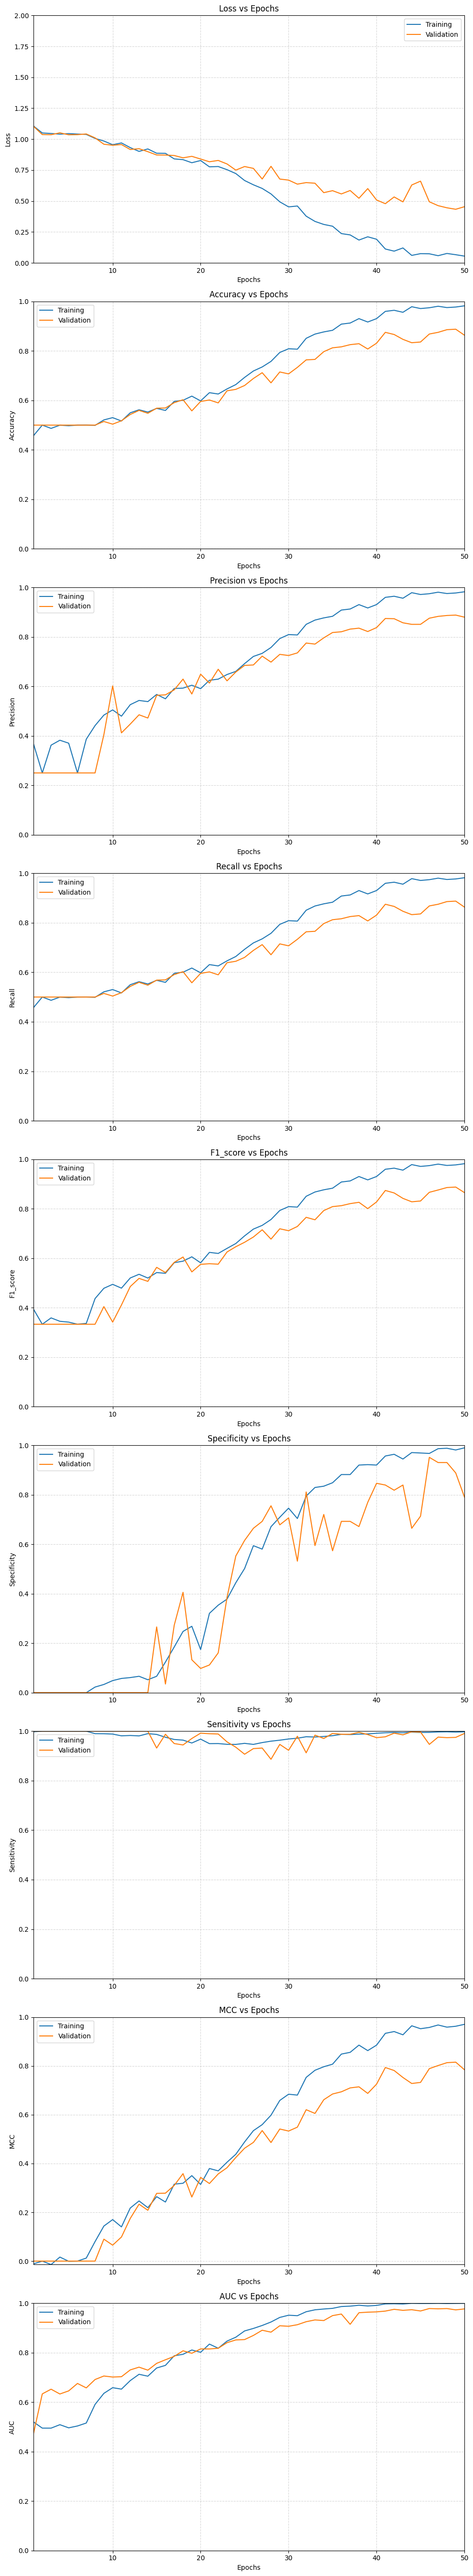

In [25]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

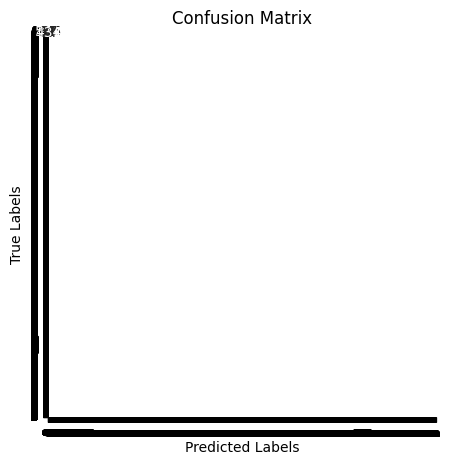

In [26]:
# Confusion Matrix
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

# Plot Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()